In [ ]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit -*-
# -*- date : 2023-11-25 -*-
# -*- Last revision: 2023-11-25 -*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarize results-*-

# <center> CS -433 Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Road Segmentation </center>
---

### Preparing environment for Google Colaboratory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ml-project-2-team-slo/source

/content/drive/MyDrive/ml-project-2-team-slo/source


### Imports

In [4]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#import model parameters
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torchvision import models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#import files
from data_processing import*
from visualization import visualize, visualize_patch
import constants
from test_data import TestData

#import models
from cnn import Basic_CNN
from logistic_regression import LogisticRegression

In [9]:
# Set random seed for reproducibility
torch.manual_seed(0)

## 1. Data wrangling and visualization

In [10]:
myDatas = AdvancedProcessing(standardize=False)
myDatas.proceed()

Loading data...
Done!
Splitting data...
Done!
Creating patches...
Creating patches for training set...
Rotation for 45 degrees
Rotation for 135 degrees
Rotation for 225 degrees
Rotation for 315 degrees
Batch 1/4000
Batch 401/4000
Batch 801/4000
Batch 1201/4000
Batch 1601/4000
Batch 2001/4000
Batch 2401/4000
Batch 2801/4000
Batch 3201/4000
Batch 3601/4000
end process...
Creating patches for validation set...
Done!
Creating dataloader...
Done!


## 2. Define and train models

### 2.1 Logistic regression

A first attempt could be to try with some linear model. The first approach here is to use a simple logistic regression. In order to use a logistic regression, one need to extract feature from the image. A choice could be to use the mean and the standard deviation as features. The following section will present these approach.

In [11]:
LogisticData = BasicProcessing()
LogisticData.load_data()
LogisticData.create_patches()

Loading data...
Done!
Creating patches...
Done!


In [12]:
LogReg = LogisticRegression(LogisticData.imgs_patches, LogisticData.gt_imgs_patches)
LogReg.compute_vectors()

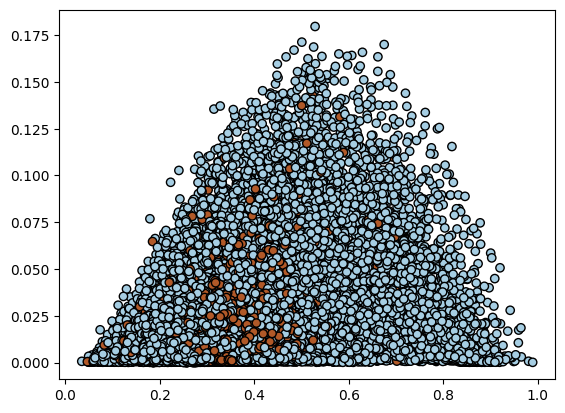

In [13]:
plt.scatter(LogReg.X[:, 0], LogReg.X[:, 1], c=LogReg.Y, edgecolors="k", cmap=plt.cm.Paired)
plt.show()

A problem already arises. The datas are not linearly separable. Let's still try to train the model.

In [14]:
LogReg.train()
LogReg.predict()

In [15]:
print(f'From this model, the accuracy is {LogReg.accuracy*100:.2f}% and the F1 score is {LogReg.f1*100:.2f}%')

From this model, the accuracy is 55.08% and the F1 score is 44.22%


The unsatisfactory results tend us to move to Convolutional Networks, which are more suitable for image datas.

### 2.2 Basic Convolutional Neural Network

In [ ]:
cnn = Basic_CNN(constants.WINDOW_SIZE)

# Define the loss function, optimizer and scheduler
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
criterion = nn.BCEWithLogitsLoss()

# Train the model
cnn.train_model(
    optimizer,
    scheduler,
    criterion,
    myDatas.train_dataloader,
    myDatas.validate_dataloader,
    num_epochs=10)